**FEEL FREE TO UPVOTE**  （＾ｖ＾）

In [1]:
#v20提交成绩得到了3.688， cv 成绩3.6519
#使用authorized_flag 进行特征分别处理,收到了奇效
#使用countVectorizer 对类别变量进行编码，内存存在压力

In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
import time
warnings.filterwarnings('ignore')
np.random.seed(4950)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# you need to obtain Wang's features from his notebook
df_train=pd.read_csv("train_wang_pur_date_4.csv")
df_test=pd.read_csv("test_wang_pur_date_4.csv")

In [4]:
# Select relevant features
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns = [c for c in df_train.columns if c not in exclude_features ]
target = df_train['target']
#del df_train['target']

In [5]:
len(df_train_columns)
len(exclude_features)

4

### Below part is based on : 
https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

In [11]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    #train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data.loc[:,df_train_columns], y, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device" : "gpu"}
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    #num_round = 1000
    #clf = lgb.train(lgb_params, dtrain, num_round, verbose_eval=100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    #clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    #oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(df_train_columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    imp_df['trn_score']=np.sqrt(mean_squared_error(y, clf.predict(data.loc[:,df_train_columns])))
    
    return imp_df


In [12]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [13]:
actual_imp_df.sort_values('importance_split',ascending=False).head()


,feature,importance_gain,importance_split,trn_score
223,new_hist_purchase_date_uptonow,1.245815e+06,307,3.587507
62,auth_hist_month_nunique,1.078921e+06,256,3.587507
84,auth_hist_purchase_date_max,1.957928e+06,214,3.587507
179,new_hist_purchase_amount_max,7.276431e+05,200,3.587507
190,new_hist_purchase_date_max,4.399690e+05,154,3.587507


In [14]:
actual_imp_df1=actual_imp_df.copy()

In [15]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
223,new_hist_purchase_date_uptonow,1.245815e+06,307,3.587507
62,auth_hist_month_nunique,1.078921e+06,256,3.587507
84,auth_hist_purchase_date_max,1.957928e+06,214,3.587507
179,new_hist_purchase_amount_max,7.276431e+05,200,3.587507
190,new_hist_purchase_date_max,4.399690e+05,154,3.587507


In [16]:
actual_imp_df.sort_values('importance_split',ascending=False).head()

,feature,importance_gain,importance_split,trn_score
223,new_hist_purchase_date_uptonow,1.245815e+06,307,3.587507
62,auth_hist_month_nunique,1.078921e+06,256,3.587507
84,auth_hist_purchase_date_max,1.957928e+06,214,3.587507
179,new_hist_purchase_amount_max,7.276431e+05,200,3.587507
190,new_hist_purchase_date_max,4.399690e+05,154,3.587507


In [17]:
import time

In [18]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  15.1 min)

In [19]:
# Save importances just in case
null_imp_df.to_csv('null_importances_distribution_ref.csv')
actual_imp_df.to_csv('actual_importances_ditribution_ref.csv')

In [90]:
#actual_imp_df=feature_importance

In [69]:
# null_imp_df=pd.read_csv('null_importances_distribution_rf.csv')

Score features
There are several ways to score features :

Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
Compute ratios like Actual / Null Max, Actual / Null Mean, Actual Mean / Null Max
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

In [20]:
import matplotlib.gridspec as gridspec
import seaborn as sns

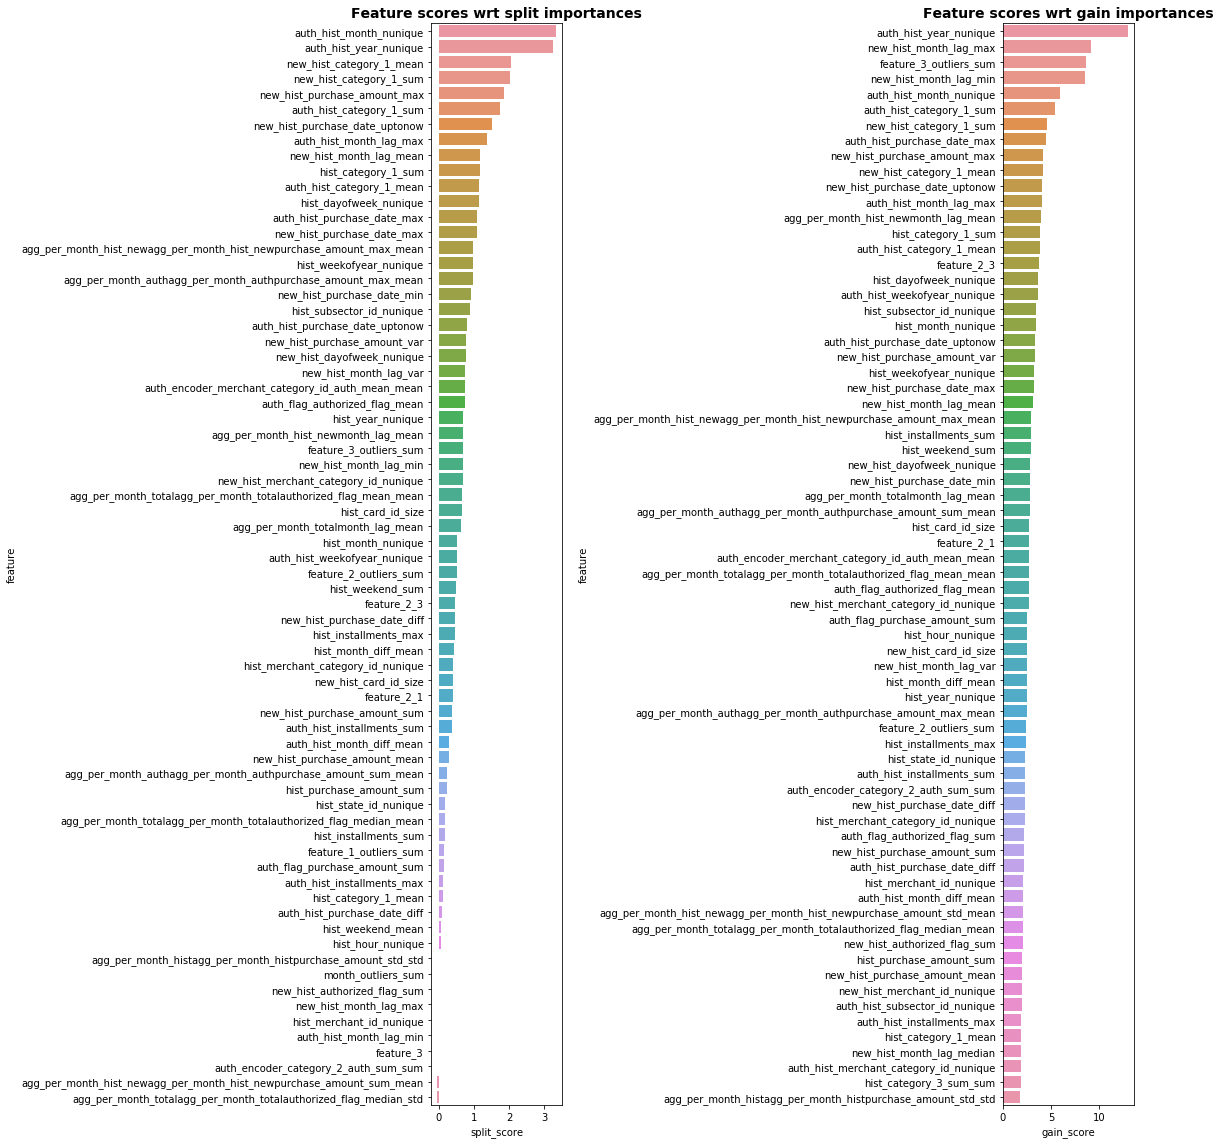

In [21]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

Check the impact of removing uncorrelated features
Here I'll use a different metric to asses correlation to the target

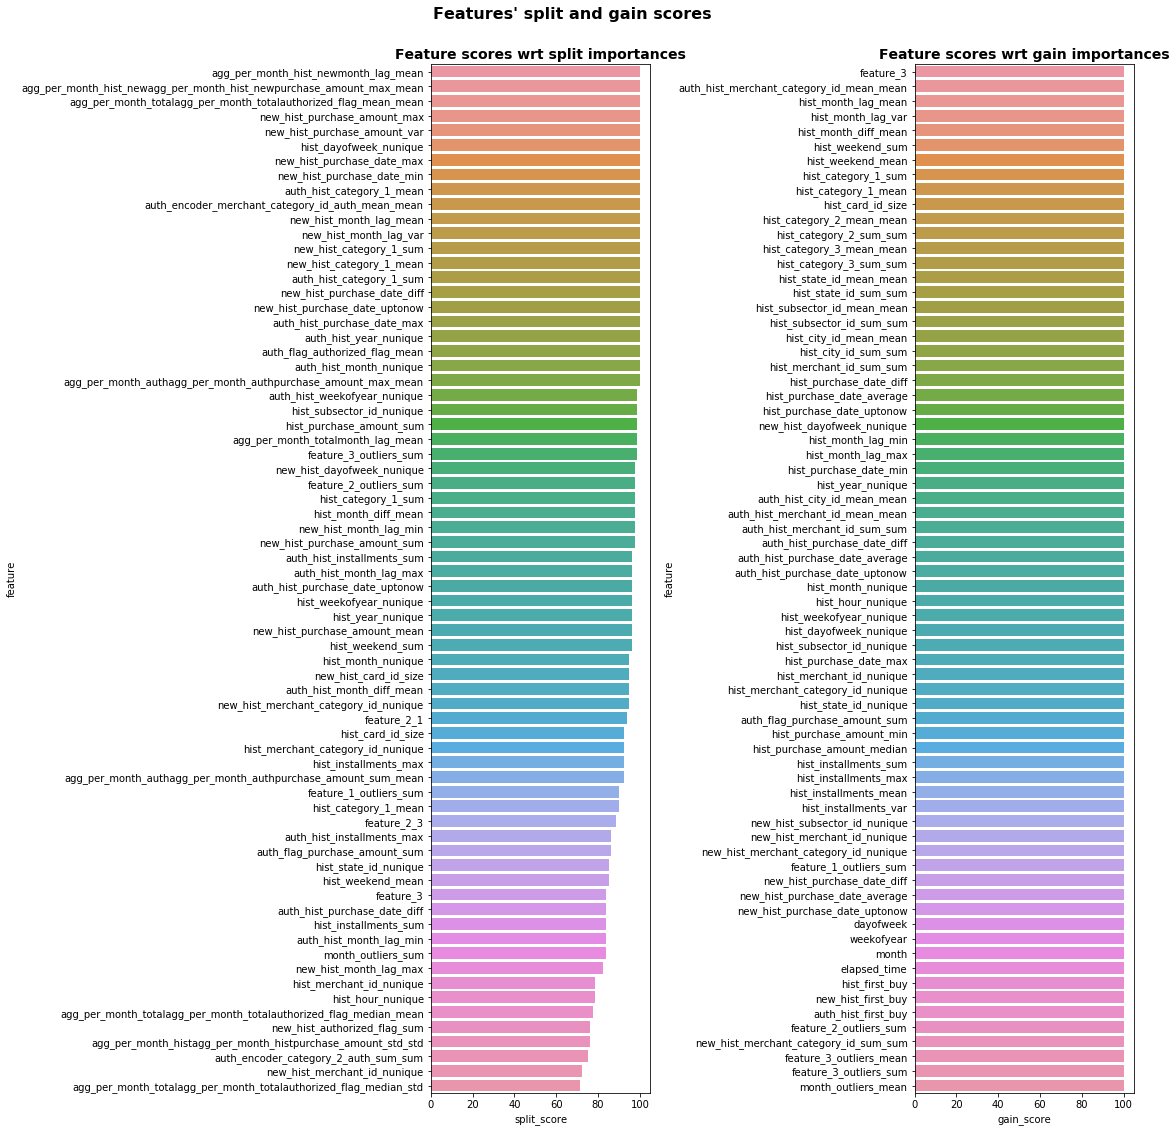

In [22]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

Score feature removal for different thresholds¶


In [23]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    print(len(split_feats))                                                           

250
141
126
113
104
93
82
72
62
51
44
22


250
131
120
110
103
91
77
70
63
49
42
21

In [25]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    
    dtrain = lgb.Dataset(df.loc[:,train_features], target, free_raw_data=False, silent=True)
    lgb_params = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        nfold=5,
        stratified=False,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last
    
    return hist['rmse-mean'][-1], hist['rmse-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

    
    

Results for threshold   0
	 SPLIT : 3.653146 +/- 0.037658
	 GAIN  : 3.652897 +/- 0.037804
Results for threshold  10
	 SPLIT : 3.647648 +/- 0.039072
	 GAIN  : 3.653331 +/- 0.037937
Results for threshold  20
	 SPLIT : 3.647432 +/- 0.038673
	 GAIN  : 3.652692 +/- 0.036717
Results for threshold  30
	 SPLIT : 3.646897 +/- 0.037545
	 GAIN  : 3.652754 +/- 0.036859
Results for threshold  40
	 SPLIT : 3.648197 +/- 0.037318
	 GAIN  : 3.652793 +/- 0.037294
Results for threshold  50
	 SPLIT : 3.648393 +/- 0.038244
	 GAIN  : 3.652936 +/- 0.036404
Results for threshold  60
	 SPLIT : 3.649571 +/- 0.037744
	 GAIN  : 3.652622 +/- 0.037274
Results for threshold  70
	 SPLIT : 3.650033 +/- 0.038307
	 GAIN  : 3.653308 +/- 0.037756
Results for threshold  80
	 SPLIT : 3.650586 +/- 0.037997
	 GAIN  : 3.652754 +/- 0.038512
Results for threshold  90
	 SPLIT : 3.650315 +/- 0.038673
	 GAIN  : 3.651892 +/- 0.037804
Results for threshold  95
	 SPLIT : 3.650438 +/- 0.039172
	 GAIN  : 3.650649 +/- 0.037946
Results fo

In [26]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950,
         "device":"gpu"}
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4950)
    oof = np.zeros(len(df))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df,df['outliers'].values)):
#    print("fold {}".format(fold_))
#     trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
#     val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],verbose_eval=0, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train_features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        #predictions += clf.predict(df_test[train_features], num_iteration=clf.best_iteration) / folds.n_splits

    return np.sqrt(mean_squared_error(oof, target))
split_results_list=[]
gain_results_list=[]
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    #split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    #gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=df_train, train_features=split_feats, cat_feats=None, target=df_train['target'])
    print('\t SPLIT : '+str(split_results))
    split_results_list.append(split_results)
    gain_results = score_feature_selection(df=df_train, train_features=gain_feats, cat_feats=None, target=df_train['target'])
    print('\t GAIN  : '+ str(gain_results))
    gain_results_list.append(gain_results)

Results for threshold   0
	 SPLIT : 3.6484018952544326
	 GAIN  : 3.6484226073158883
Results for threshold  10
	 SPLIT : 3.6434054788343415
	 GAIN  : 3.6472503183399625
Results for threshold  20
	 SPLIT : 3.642360962423135
	 GAIN  : 3.6477317076031786
Results for threshold  30
	 SPLIT : 3.6421920515615733
	 GAIN  : 3.6475301453386213
Results for threshold  40
	 SPLIT : 3.642776502946419
	 GAIN  : 3.647816366977118
Results for threshold  50
	 SPLIT : 3.64413776947727
	 GAIN  : 3.6484694425327446
Results for threshold  60
	 SPLIT : 3.644424083193426
	 GAIN  : 3.6480725041627813
Results for threshold  70
	 SPLIT : 3.6464365104925407
	 GAIN  : 3.647310178242289
Results for threshold  80
	 SPLIT : 3.647318033571599
	 GAIN  : 3.647825717441616
Results for threshold  90
	 SPLIT : 3.6455602877220565
	 GAIN  : 3.645975611167717
Results for threshold  95
	 SPLIT : 3.646905900288914
	 GAIN  : 3.647941008152925
Results for threshold  99
	 SPLIT : 3.6623268301835723
	 GAIN  : 3.6453844505028195


In [27]:
split_results_list

[3.6484018952544326,
 3.6434054788343415,
 3.642360962423135,
 3.6421920515615733,
 3.642776502946419,
 3.64413776947727,
 3.644424083193426,
 3.6464365104925407,
 3.647318033571599,
 3.6455602877220565,
 3.646905900288914,
 3.6623268301835723]

In [107]:
str(split_results)

'3.648584990565712'

Results for threshold   0
	 SPLIT : 3.653525 +/- 0.037462
	 GAIN  : 3.653525 +/- 0.037462
Results for threshold  10
	 SPLIT : 3.647332 +/- 0.038810
	 GAIN  : 3.653906 +/- 0.037102
Results for threshold  20
	 SPLIT : 3.648605 +/- 0.038934
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  30
	 SPLIT : 3.647871 +/- 0.037349
	 GAIN  : 3.651490 +/- 0.037606
Results for threshold  40
	 SPLIT : 3.647575 +/- 0.036816
	 GAIN  : 3.652654 +/- 0.037044
Results for threshold  50
	 SPLIT : 3.647932 +/- 0.037084
	 GAIN  : 3.652254 +/- 0.037573
Results for threshold  60
	 SPLIT : 3.647611 +/- 0.036503
	 GAIN  : 3.651592 +/- 0.037231
Results for threshold  70
	 SPLIT : 3.647497 +/- 0.037576
	 GAIN  : 3.651549 +/- 0.037122
Results for threshold  80
	 SPLIT : 3.649732 +/- 0.037814
	 GAIN  : 3.652329 +/- 0.037058
Results for threshold  90
	 SPLIT : 3.651710 +/- 0.037993
	 GAIN  : 3.651960 +/- 0.037423
Results for threshold  95
	 SPLIT : 3.654297 +/- 0.038320
	 GAIN  : 3.651504 +/- 0.037540
Results for threshold  99
	 SPLIT : 3.663244 +/- 0.040049
	 GAIN  : 3.651141 +/- 0.037911

In [29]:
corr_scores_df.to_csv('correlation_feature_scores.csv')

In [28]:
split_results

3.6623268301835723

In [47]:
for i in [10,20,30,40]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= i]
    df_split_feats=pd.DataFrame(split_feats)
    df_split_feats.to_csv('threshold_feature_elimination'+str(i)+'.csv',index=False)


In [48]:
test=pd.read_csv('threshold_feature_elimination10.csv')
test.shape

(141, 1)

In [49]:
test


,0
0,feature_3
1,auth_flag_purchase_amount_sum
2,auth_flag_authorized_flag_sum
3,auth_flag_authorized_flag_mean
4,auth_flag_authorized_flag_std
5,auth_flag_card_id_size
6,auth_encoder_category_2_auth_sum_sum
7,auth_encoder_category_3_auth_mean_mean
8,auth_encoder_category_3_auth_sum_sum
9,auth_encoder_subsector_id_auth_mean_mean


In [45]:
corr_scores_df.sort_values('split_score',ascending=False).feature.head(50)

50                  agg_per_month_hist_newmonth_lag_mean
58     agg_per_month_hist_newagg_per_month_hist_newpu...
22     agg_per_month_totalagg_per_month_totalauthoriz...
179                         new_hist_purchase_amount_max
182                         new_hist_purchase_amount_var
118                               hist_dayofweek_nunique
190                           new_hist_purchase_date_max
191                           new_hist_purchase_date_min
96                             auth_hist_category_1_mean
14      auth_encoder_merchant_category_id_auth_mean_mean
194                              new_hist_month_lag_mean
195                               new_hist_month_lag_var
204                              new_hist_category_1_sum
205                             new_hist_category_1_mean
95                              auth_hist_category_1_sum
221                          new_hist_purchase_date_diff
223                       new_hist_purchase_date_uptonow
84                           au